In [254]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import string
import re

from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sqlalchemy import create_engine
from confident import *

In [255]:
df = pd.read_csv('datasets/billboard.zip')
df.head()

,date,year,title,simple_title,artist,main_artist,peak_pos,last_pos,weeks,rank,...,acousticness,instrumentalness,time_signature,danceability,key,duration_ms,loudness,valence,mode,lyrics
0,6/21/18,NaN,4th Dimension,NaN,Kanye West and Kid Cudi,NaN,42,0,1,42,...,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,Error: Could not find lyrics.
1,6/21/18,NaN,All Girls Are The Same,NaN,Juice WRLD,NaN,41,49,5,41,...,0.0769,0.000335,4,0.671,0,165820,-7.226,0.203,1,"They're rotting my brain, love\nThese hoes are..."
2,6/21/18,NaN,All Mine,NaN,Kanye West,NaN,11,11,2,31,...,0.125,0,4,0.925,11,145507,-6.562,0.265,0,"Yeah, you supermodel thick\nDamn, that ass bus..."
3,6/21/18,NaN,Alone,NaN,Halsey Featuring Big Sean & Stefflon Don,NaN,70,73,9,74,...,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,Error: Could not find lyrics.
4,6/21/18,NaN,Babe,NaN,Sugarland Featuring Taylor Swift,NaN,72,0,2,95,...,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,Error: Could not find lyrics.


In [256]:
df.shape

(7573, 31)

In [257]:
# Removing all rows that did not return lyrics
df = df[df['lyrics'].str.contains("Error: Could not find lyrics.") == False]

In [258]:
df.shape

(7228, 31)

In [259]:
df.head()

,date,year,title,simple_title,artist,main_artist,peak_pos,last_pos,weeks,rank,...,acousticness,instrumentalness,time_signature,danceability,key,duration_ms,loudness,valence,mode,lyrics
1,6/21/18,NaN,All Girls Are The Same,NaN,Juice WRLD,NaN,41,49,5,41,...,0.0769,0.000335,4,0.671,0,165820,-7.226,0.203,1,"They're rotting my brain, love\nThese hoes are..."
2,6/21/18,NaN,All Mine,NaN,Kanye West,NaN,11,11,2,31,...,0.125,0,4,0.925,11,145507,-6.562,0.265,0,"Yeah, you supermodel thick\nDamn, that ass bus..."
5,6/21/18,NaN,Back To You,NaN,Selena Gomez,NaN,22,31,5,22,...,0.0945,1.68E-06,4,0.601,6,207905,-4.856,0.508,1,Took you like a shot\nThought that I could cha...
7,6/21/18,NaN,Be Careful,NaN,Cardi B,NaN,11,25,11,23,...,0.0256,0,4,0.82,6,210787,-8.23,0.535,0,"Yeah\nBe careful, be careful, be careful with ..."
8,6/21/18,NaN,Beautiful Crazy,NaN,Luke Combs,NaN,58,77,4,93,...,0.676,0,4,0.552,11,193200,-7.431,0.382,1,Her day starts with a coffee\nAnd ends with a ...


In [260]:
# Removing unnecessary columns from the dataframe
cols = ['simple_title', 'main_artist', 'year', 'peak_pos', 'last_pos', 'weeks', 'rank', 'change', 'video_link', 'broad_genre']
df = df.drop(cols, axis=1)

In [261]:
df.head()

,date,title,artist,spotify_link,spotify_id,genre,analysis_url,energy,liveness,tempo,...,acousticness,instrumentalness,time_signature,danceability,key,duration_ms,loudness,valence,mode,lyrics
1,6/21/18,All Girls Are The Same,Juice WRLD,spotify:track:0XySogm94T51XF5F2jumXm,0XySogm94T51XF5F2jumXm,[u'rap'],https://api.spotify.com/v1/audio-analysis/0XyS...,0.529,0.0856,161.989,...,0.0769,0.000335,4,0.671,0,165820,-7.226,0.203,1,"They're rotting my brain, love\nThese hoes are..."
2,6/21/18,All Mine,Kanye West,spotify:track:3qnoOm4fwZPBS116f5hpgF,3qnoOm4fwZPBS116f5hpgF,"[u'pop rap', u'rap']",https://api.spotify.com/v1/audio-analysis/3qno...,0.308,0.0933,122.099,...,0.125,0,4,0.925,11,145507,-6.562,0.265,0,"Yeah, you supermodel thick\nDamn, that ass bus..."
5,6/21/18,Back To You,Selena Gomez,spotify:track:4hQ6UGyWQIGJmHSo0J88JW,4hQ6UGyWQIGJmHSo0J88JW,"[u'dance pop', u'pop', u'post-teen pop']",https://api.spotify.com/v1/audio-analysis/4hQ6...,0.724,0.12,102.061,...,0.0945,1.68E-06,4,0.601,6,207905,-4.856,0.508,1,Took you like a shot\nThought that I could cha...
7,6/21/18,Be Careful,Cardi B,spotify:track:2Yl4OmDby9iitgNWZPwxkd,2Yl4OmDby9iitgNWZPwxkd,"[u'pop', u'rap']",https://api.spotify.com/v1/audio-analysis/2Yl4...,0.568,0.0952,152.279,...,0.0256,0,4,0.82,6,210787,-8.23,0.535,0,"Yeah\nBe careful, be careful, be careful with ..."
8,6/21/18,Beautiful Crazy,Luke Combs,spotify:track:4Qx06Fzsepmdz2NGSWfZck,4Qx06Fzsepmdz2NGSWfZck,"[u'contemporary country', u'country road']",https://api.spotify.com/v1/audio-analysis/4Qx0...,0.402,0.0928,103.313,...,0.676,0,4,0.552,11,193200,-7.431,0.382,1,Her day starts with a coffee\nAnd ends with a ...


In [262]:
# This function removes the unnecessary "u" from each list of genres.
def genre_preprocess(text : str) -> str:
    text = re.sub("u'", "'", text)
    return text

In [263]:
# Run the function defined above on the "genre" column
df['genre'] = df.genre.apply(genre_preprocess)
df.head()

,date,title,artist,spotify_link,spotify_id,genre,analysis_url,energy,liveness,tempo,...,acousticness,instrumentalness,time_signature,danceability,key,duration_ms,loudness,valence,mode,lyrics
1,6/21/18,All Girls Are The Same,Juice WRLD,spotify:track:0XySogm94T51XF5F2jumXm,0XySogm94T51XF5F2jumXm,['rap'],https://api.spotify.com/v1/audio-analysis/0XyS...,0.529,0.0856,161.989,...,0.0769,0.000335,4,0.671,0,165820,-7.226,0.203,1,"They're rotting my brain, love\nThese hoes are..."
2,6/21/18,All Mine,Kanye West,spotify:track:3qnoOm4fwZPBS116f5hpgF,3qnoOm4fwZPBS116f5hpgF,"['pop rap', 'rap']",https://api.spotify.com/v1/audio-analysis/3qno...,0.308,0.0933,122.099,...,0.125,0,4,0.925,11,145507,-6.562,0.265,0,"Yeah, you supermodel thick\nDamn, that ass bus..."
5,6/21/18,Back To You,Selena Gomez,spotify:track:4hQ6UGyWQIGJmHSo0J88JW,4hQ6UGyWQIGJmHSo0J88JW,"['dance pop', 'pop', 'post-teen pop']",https://api.spotify.com/v1/audio-analysis/4hQ6...,0.724,0.12,102.061,...,0.0945,1.68E-06,4,0.601,6,207905,-4.856,0.508,1,Took you like a shot\nThought that I could cha...
7,6/21/18,Be Careful,Cardi B,spotify:track:2Yl4OmDby9iitgNWZPwxkd,2Yl4OmDby9iitgNWZPwxkd,"['pop', 'rap']",https://api.spotify.com/v1/audio-analysis/2Yl4...,0.568,0.0952,152.279,...,0.0256,0,4,0.82,6,210787,-8.23,0.535,0,"Yeah\nBe careful, be careful, be careful with ..."
8,6/21/18,Beautiful Crazy,Luke Combs,spotify:track:4Qx06Fzsepmdz2NGSWfZck,4Qx06Fzsepmdz2NGSWfZck,"['contemporary country', 'country road']",https://api.spotify.com/v1/audio-analysis/4Qx0...,0.402,0.0928,103.313,...,0.676,0,4,0.552,11,193200,-7.431,0.382,1,Her day starts with a coffee\nAnd ends with a ...


In [264]:
df.shape

(7228, 21)

In [265]:
# This function cleans the text in the "lyrics" column
def clean_lyrics(text):
    text = text.lower()
    text = text.encode('ascii', 'ignore').decode()
    stop_words = stopwords.words('english')
    text = ' '.join([word for word in text.split(' ') if word not in stop_words])
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub(r'\w*\d+\w*', '', text)
    text = re.sub('\s{2,}', ' ', text)
    text = re.sub('\n', ' ', text)
    text = re.sub(' s ', ' ', text)
    text = re.sub(' m ', ' ', text)
    return text

In [266]:
# Apply the function defined above onto the "lyrics" colummn, also creating a new column called "clean_lyrics" as to not overwrite the original "lyrics" column
df['clean_lyrics'] = df.lyrics.apply(clean_lyrics)

In [267]:
# Removes unnecessary white space and ensures each word is delimited by a single space.
text = " ".join(i for i in df.clean_lyrics)

In [268]:
df.head()

,date,title,artist,spotify_link,spotify_id,genre,analysis_url,energy,liveness,tempo,...,instrumentalness,time_signature,danceability,key,duration_ms,loudness,valence,mode,lyrics,clean_lyrics
1,6/21/18,All Girls Are The Same,Juice WRLD,spotify:track:0XySogm94T51XF5F2jumXm,0XySogm94T51XF5F2jumXm,['rap'],https://api.spotify.com/v1/audio-analysis/0XyS...,0.529,0.0856,161.989,...,0.000335,4,0.671,0,165820,-7.226,0.203,1,"They're rotting my brain, love\nThese hoes are...",they re rotting brain love these hoes same i a...
2,6/21/18,All Mine,Kanye West,spotify:track:3qnoOm4fwZPBS116f5hpgF,3qnoOm4fwZPBS116f5hpgF,"['pop rap', 'rap']",https://api.spotify.com/v1/audio-analysis/3qno...,0.308,0.0933,122.099,...,0,4,0.925,11,145507,-6.562,0.265,0,"Yeah, you supermodel thick\nDamn, that ass bus...",yeah supermodel thick damn ass bustin bottom i...
5,6/21/18,Back To You,Selena Gomez,spotify:track:4hQ6UGyWQIGJmHSo0J88JW,4hQ6UGyWQIGJmHSo0J88JW,"['dance pop', 'pop', 'post-teen pop']",https://api.spotify.com/v1/audio-analysis/4hQ6...,0.724,0.12,102.061,...,1.68E-06,4,0.601,6,207905,-4.856,0.508,1,Took you like a shot\nThought that I could cha...,took like shot thought could chase cold evenin...
7,6/21/18,Be Careful,Cardi B,spotify:track:2Yl4OmDby9iitgNWZPwxkd,2Yl4OmDby9iitgNWZPwxkd,"['pop', 'rap']",https://api.spotify.com/v1/audio-analysis/2Yl4...,0.568,0.0952,152.279,...,0,4,0.82,6,210787,-8.23,0.535,0,"Yeah\nBe careful, be careful, be careful with ...",yeah be careful careful careful me yeah look i...
8,6/21/18,Beautiful Crazy,Luke Combs,spotify:track:4Qx06Fzsepmdz2NGSWfZck,4Qx06Fzsepmdz2NGSWfZck,"['contemporary country', 'country road']",https://api.spotify.com/v1/audio-analysis/4Qx0...,0.402,0.0928,103.313,...,0,4,0.552,11,193200,-7.431,0.382,1,Her day starts with a coffee\nAnd ends with a ...,day starts coffee and ends wine takes forever ...


In [269]:
df.shape

(7228, 22)

In [270]:
# Dropping all duplicates from the dataset. Some of the spotify IDs were duplicated
df = df.drop_duplicates(subset='spotify_id')

In [271]:
# Dropping all rows with a NULL value for the spotify_id column
df = df.dropna(subset=['spotify_id'])

In [272]:
# Reseting the index count to avoid multiple rows having the same index and to avoid fractured index counts.
df = df.reset_index(drop=True)
df.head()

,date,title,artist,spotify_link,spotify_id,genre,analysis_url,energy,liveness,tempo,...,instrumentalness,time_signature,danceability,key,duration_ms,loudness,valence,mode,lyrics,clean_lyrics
0,6/21/18,All Girls Are The Same,Juice WRLD,spotify:track:0XySogm94T51XF5F2jumXm,0XySogm94T51XF5F2jumXm,['rap'],https://api.spotify.com/v1/audio-analysis/0XyS...,0.529,0.0856,161.989,...,0.000335,4,0.671,0,165820,-7.226,0.203,1,"They're rotting my brain, love\nThese hoes are...",they re rotting brain love these hoes same i a...
1,6/21/18,All Mine,Kanye West,spotify:track:3qnoOm4fwZPBS116f5hpgF,3qnoOm4fwZPBS116f5hpgF,"['pop rap', 'rap']",https://api.spotify.com/v1/audio-analysis/3qno...,0.308,0.0933,122.099,...,0,4,0.925,11,145507,-6.562,0.265,0,"Yeah, you supermodel thick\nDamn, that ass bus...",yeah supermodel thick damn ass bustin bottom i...
2,6/21/18,Back To You,Selena Gomez,spotify:track:4hQ6UGyWQIGJmHSo0J88JW,4hQ6UGyWQIGJmHSo0J88JW,"['dance pop', 'pop', 'post-teen pop']",https://api.spotify.com/v1/audio-analysis/4hQ6...,0.724,0.12,102.061,...,1.68E-06,4,0.601,6,207905,-4.856,0.508,1,Took you like a shot\nThought that I could cha...,took like shot thought could chase cold evenin...
3,6/21/18,Be Careful,Cardi B,spotify:track:2Yl4OmDby9iitgNWZPwxkd,2Yl4OmDby9iitgNWZPwxkd,"['pop', 'rap']",https://api.spotify.com/v1/audio-analysis/2Yl4...,0.568,0.0952,152.279,...,0,4,0.82,6,210787,-8.23,0.535,0,"Yeah\nBe careful, be careful, be careful with ...",yeah be careful careful careful me yeah look i...
4,6/21/18,Beautiful Crazy,Luke Combs,spotify:track:4Qx06Fzsepmdz2NGSWfZck,4Qx06Fzsepmdz2NGSWfZck,"['contemporary country', 'country road']",https://api.spotify.com/v1/audio-analysis/4Qx0...,0.402,0.0928,103.313,...,0,4,0.552,11,193200,-7.431,0.382,1,Her day starts with a coffee\nAnd ends with a ...,day starts coffee and ends wine takes forever ...


In [273]:
df.shape

(6776, 22)

Text Visualization

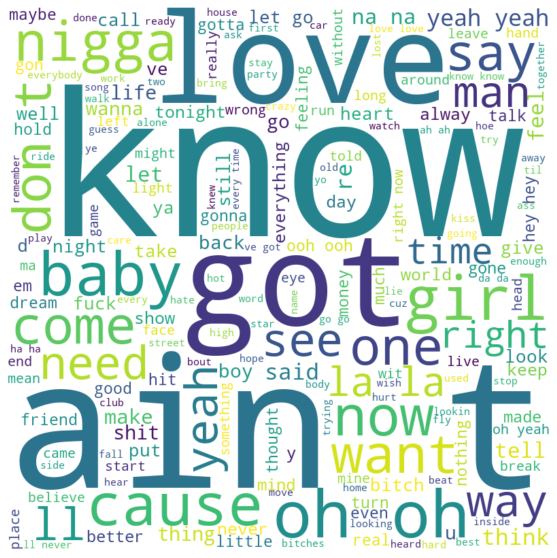

In [274]:
stopwords = set(STOPWORDS)

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(text)

plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [275]:
def get_playlist_details(df, spotify_ids):
    """This function takes in the user's playlist and returns the spotify IDs and the playlist lyrics.
    
        Args -
            df : A 2D pandas dataframe that contains the cleaned dataset.
            spotify_id : A list of strings that contains the spotify IDs of the users playlist
             
        Returns -
            user_playlist_song_ids : A list of strings that contains the song IDs of the user's playlist.
            user_playlist_lyrics : A single string that contains all of the lyrics of the user's playlist.
            """
    

    row_num = df[df['spotify_id'].isin(spotify_ids)]
    print("Playlist User Enterd:")
    print(row_num[['title', 'artist', 'spotify_id']])

    # Get the Spotify IDs for the songs in the user's playlist
    user_playlist_song_ids = row_num['spotify_id']

    # Combine the lyrics from each of the songs in the user's playlist into one string
    user_playlist_lyrics = ' '.join(row_num['clean_lyrics'].tolist())

    # Return the Spotify song IDs and the string containing the lyrics of the entire playlist
    return user_playlist_song_ids, user_playlist_lyrics

Here I am generating a random playlist in order to test the function. 
    - I generate a random playlist.
    - Pass in the dataframe containing all songs and the spotify IDs from the playlist I just generated.
    - Return the song IDs and the lyrics from the playlist

In [276]:
sp_ids = df['spotify_id']
user_playlist_song_ids, user_playlist_lyrics = get_playlist_details(df=df, spotify_ids=sp_ids.sample(n=7))

Playlist User Enterd:
                   title         artist              spotify_id
304             Criminal  natti natasha  6Za3190Sbw39BBC77WSS1C
2838                Mean   taylor swift  5yEPktRqvIhko5QFF3aBhQ
3437               Still     tim mcgraw  0GHQjsiligq44QGUePXntw
3865  Lark On My Go-Kart     asher roth  7g1yl3UgC1m0E1qPqCDwwZ
4078  Ready For Whatever           t.i.  6LZEELfdEt8NOE9jsJppvN
5009    Good Ride Cowboy   garth brooks  596KxlJVRMeLDw8JzEBwWH
5856       Rock You Baby     toby keith  1hDyukwpyJ9H5QBZoIs0Dm


Here I am creating a Tf-idf vectorizer object, and fitting the clean lyrics column onto it.

In [277]:
def generate_recommendations(user_playlist_song_ids, user_playlist_lyrics):

    # Create a new column with the combined clean lyrics for each song
    clean_lyrics = df['clean_lyrics']

    # Create a Tf-idf vectorizer object
    vectorizer = TfidfVectorizer()

    # Fit the vectorizer to the lyrics, creating a tf-idf matrix where the words are the features
    tfidf_matrix = vectorizer.fit_transform(clean_lyrics)

    # Transform the user playlist into a Tf-idf vector
    user_tfidf = vectorizer.transform([user_playlist_lyrics])

    # Calculate the cosine similarities between the user playlist vector and all the songs
    cosine_similarities = cosine_similarity(user_tfidf, tfidf_matrix).flatten()

    # Sort the songs by similarity score in descending order
    song_indices = cosine_similarities.argsort()[::-1]

    # Get the top N number of song recommendations without duplicating the songs in the user's playlist
    recommended_songs = []
    for i in song_indices:
        if len(recommended_songs) == 10:
            break
        elif df.loc[i, 'spotify_id'] in user_playlist_song_ids:
            continue
        else:
            recommended_songs.append(df.loc[i, 'spotify_id'])

    # Return the recommended songs, what is returned are the spotify IDs of the songs
    return recommended_songs

In [278]:
# Test the function
recommendations = generate_recommendations(user_playlist_song_ids=user_playlist_song_ids, user_playlist_lyrics=user_playlist_lyrics)

# Obtaining the details (i.e the song title and artist) from the spotify IDs returned by the generate_recommendations function.
song_details = df[df['spotify_id'].isin(recommendations)].drop_duplicates(subset='spotify_id')

Evaluating the TF-IDF function

In [279]:
NUM_USERS = 100

# Create a list of user IDs and item IDs
user_ids = ['user{}'.format(i) for i in range (1, NUM_USERS + 1)]

# Grab all spotify IDs from the dataset
spotify_ids = df['spotify_id'].unique()

# Create a user-item matrix with random values for each user 
data = np.random.randint(0, 101, size=(100, 6776))
user_item_matrix = pd.DataFrame(data=data, index=user_ids, columns=spotify_ids)

In [280]:
# Find the maximum value for each user
max_vals = np.max(user_item_matrix, axis=1)

# Calculate the threshold value for the top 10% of the highest numbers in each row
thresholds = max_vals * 0.9

# Identify the columns that have values in the top 10% of the highest numbers in each row for each user
top_cols = user_item_matrix.values >= thresholds[:, np.newaxis]

# Convert the result to a DataFrame with the same columns as the input
top_cols_df = pd.DataFrame(top_cols, columns=user_item_matrix.columns)

# Rename the rows to match the user IDs
top_cols_df.index = user_item_matrix.index

/var/folders/b8/tkxd7yxj1672bq9d4m_3xmhh0000gn/T/ipykernel_203/4220784890.py:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  top_cols = user_item_matrix.values >= thresholds[:, np.newaxis]


In [281]:
# Generate a random playlist for each user with 10 songs
user_playlists = {}
for user in user_ids:
    user_value = [ord(char) for char in user]
    user_value = int(sum(user_value) / len(user_value)) + random.randint(1, 100)
    np.random.seed(user_value) # use the user ID as the seed
    user_playlists[user] = np.random.choice(spotify_ids, size=10, replace=False)

user_recommendations = {}
for user, playlist in user_playlists.items():
    user_playlist_song_ids, user_playlist_lyrics = get_playlist_details(df=df, spotify_ids=playlist)
    user_recommendations[user] = generate_recommendations(user_playlist_song_ids=user_playlist_song_ids, user_playlist_lyrics=user_playlist_lyrics)

    # Obtaining the details (i.e the song title and artist) from the spotify IDs returned by the generate_recommendations function.
    song_details = df[df['spotify_id'].isin(user_recommendations[user])].drop_duplicates(subset='spotify_id')

Playlist User Enterd:
                           title              artist              spotify_id
791                Slumber Party      britney spears  2i9q8CteBmpslOJeQdMGqA
1354         Dear Future Husband      meghan trainor  10Lqmv7SXFxyfzk3gbgMMa
1767  Can't Help Falling In Love   christina grimmie  5l5oJ7rf3ZODYsrAS1hah4
2167                  Pour It Up             rihanna  5r67bGhYXZNqk2m2Wupfmu
2284            Don't Wake Me Up         chris brown  12Ns5IphkblPmHxpRILG9t
2995                     Walking           mary mary  05kpDKj3MNFtZOlKkfurGG
3762             Turn My Swag On  soulja boy tell'em  6ATrsVaZT7XjkCynxM8cTS
4683         Best Of Both Worlds      hannah montana  2Jl67aezGtgrcKKVl9R2Ou
5155                      Energy             natalie  7B42GdidcsaQdJCBiPtzSW
5854                   B R Right               trina  7iKXO3oCFiiZRniwAJaGa4
Playlist User Enterd:
                       title                artist              spotify_id
302        Ask Me How I Know      

In [282]:
# Generate the precision, recall, and F1 scores for the recommendation function based on the user-item matrix and if the song recommended is in the top 10% of the highest numbers in each row for each user
def evaluate_recommendations(user_recommendations : dict, user_item_matrix, top_cols_df):
    """
    This function will evaluate the recommendations generated by the generate_recommendations function.
    It will calculate the precision, recall, and F1 scores for the recommendation function based on the user-item matrix and if the song recommended is in the top 10% of the highest numbers in each row for each user.
    
    :param user_recommendations: A dictionary of user IDs and the Spotify IDs of recommended songs for each user.
    :param user_item_matrix: A user-item matrix with the user IDs as the index and the Spotify IDs as the columns.
    :param top_cols_df: A DataFrame with the user IDs as the index and the Spotify IDs as the columns. The values are True if the song is in the top 10% of the highest numbers in each row for each user.

    :return: A list of precision, recall, and F1 scores.
    """


    # Create a list to store the precision, recall, and F1 scores
    scores = []

    # Loop through each user and their recommended songs
    for user, recommendations in user_recommendations.items():
        # Get the top 10% of the highest numbers in each row for each user
        top_cols = top_cols_df.loc[user, :]

        # Get the songs that are in the top 10% of the highest numbers in each row for each user
        top_songs = top_cols[top_cols == True].index.tolist()

        # Get the songs that were recommended to the user
        recommended_songs = user_recommendations[user]

        # Calculate the precision score
        precision = len(set(recommended_songs).intersection(set(top_songs))) / len(recommended_songs)

        # Calculate the recall score
        recall = len(set(recommended_songs).intersection(set(top_songs))) / len(top_songs)

        # Calculate the F1 Score without ZeroDivisonError
        if precision == 0 and recall == 0:
            f1 = 0
        else:
            f1 = 2 * (precision * recall) / (precision + recall)

        # Append the precision, recall, and F1 scores to the scores list
        scores.append([precision, recall, f1])

    # Convert the scores list to a DataFrame
    scores_df = pd.DataFrame(scores, columns=['Precision', 'Recall', 'F1'])

    # Return the scores DataFrame
    return scores_df

In [283]:
# Call the evaluate_recommendations function
scores_df = evaluate_recommendations(user_recommendations=user_recommendations, user_item_matrix=user_item_matrix, top_cols_df=top_cols_df)

In [284]:
# Print the average precision, recall, and F1 scores
print("Average Precision: ", scores_df['Precision'].mean())
print("Average Recall: ", scores_df['Recall'].mean())
print("Average F1: ", scores_df['F1'].mean())

Average Precision:  0.10099999999999999
Average Recall:  0.0013777599258595768
Average F1:  0.0027183834869930258


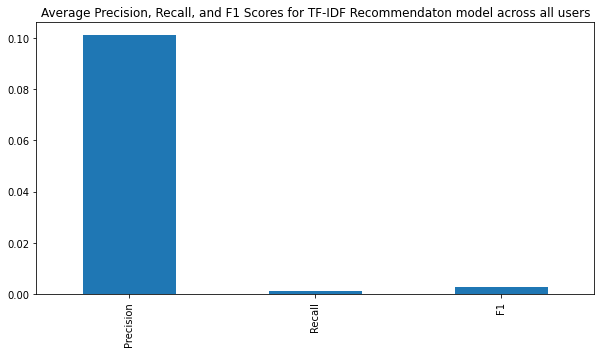

In [285]:
# Show the Precision, Recall, and F1 Scores averaged across all users on a line plot
scores_df.mean().plot(kind='bar', title='Average Precision, Recall, and F1 Scores for TF-IDF Recommendaton model across all users', figsize=(10, 5))
plt.show()

In [286]:
# Calculate the cosine similarity between matrix
cosine_sim_matrix = cosine_similarity(user_item_matrix)

In [294]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

KNN_NUM_USERS = 100

# Create a list of user IDs and item IDs
user_ids = ['user{}'.format(i) for i in range(1, KNN_NUM_USERS + 1)]

# Grab all Spotify IDs from the dataset
spotify_ids = df['spotify_id'].unique()

# Create a user-item matrix with random values for each user
data = np.random.randint(0, 101, size=(NUM_USERS, 6776))
user_item_matrix = pd.DataFrame(data=data, index=user_ids, columns=spotify_ids)

# Step 2: Compute item-item similarity using cosine similarity
item_similarity = cosine_similarity(user_item_matrix.T)

# Step 3: Identify k-nearest neighbors
k = 5  # Number of nearest neighbors to consider
# Create an array to store the indices of k-nearest neighbors for each item
k_nearest_neighbors = np.argpartition(item_similarity, -k, axis=1)[:, -k:]

# Step 4: Predict ratings
def predict_ratings(user_item_matrix, item_similarity, k_nearest_neighbors):
    predicted_ratings = np.zeros_like(user_item_matrix)
    for i in range(user_item_matrix.shape[0]):  # Loop over each user
        unrated_items = np.where(user_item_matrix.iloc[i] == 0)[0]  # Indices of unrated items
        for j in unrated_items:  # Loop over each unrated item
            # Compute predicted rating by aggregating ratings of k-nearest neighbors
            rated_items = np.where(user_item_matrix.iloc[i] != 0)[0]  # Indices of rated items
            numerator = np.sum(user_item_matrix.iloc[i].values[rated_items] * item_similarity[j][rated_items])
            denominator = np.sum(np.abs(item_similarity[j][rated_items]))
            if denominator != 0:
                predicted_ratings[i, j] = numerator / denominator

    return predicted_ratings

predicted_ratings = predict_ratings(user_item_matrix, item_similarity, k_nearest_neighbors)

# Step 5: Generate recommendations
def generate_recommendations(predicted_ratings, n=10):
    # Sort predicted ratings in descending order and select top-n songs as recommendations
    recommendations = np.argsort(predicted_ratings, axis=1)[:, :-n-1:-1]
    return recommendations

recommended_songs = generate_recommendations(predicted_ratings, n=10)

# print(recommended_songs)

# Generate recommendations for each user
knn_user_recommendations = {}
for i in range(user_item_matrix.shape[0]):
    knn_user_recommendations[user_item_matrix.index[i]] = recommended_songs[i]

In [295]:
# Loop through each user and their recommended songs and return the spotify IDs for the corresponding index of the recommended songs
knn_user_recommendations = {user: [df.iloc[recommendation]['spotify_id'] for recommendation in recommendations] for user, recommendations in knn_user_recommendations.items()}

In [296]:
# Call the evaluate recommendations function
knn_scores_df = evaluate_recommendations(user_recommendations=knn_user_recommendations, user_item_matrix=user_item_matrix, top_cols_df=top_cols_df)

# Set the index of the scores DataFrame to the user IDs
knn_scores_df.index = user_item_matrix.index

Average Precision:  0.10200000000000001
Average Recall:  0.001384913643296226
Average F1:  0.002732673666627954


<AxesSubplot:title={'center':'Average Precision, Recall, and F1 Scores for KNN Recommendation model across all users'}>

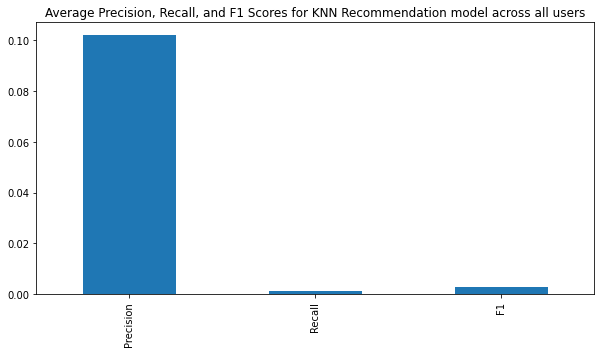

In [297]:
# Print the average precision, recall, and F1 scores
print("Average Precision: ", knn_scores_df['Precision'].mean())
print("Average Recall: ", knn_scores_df['Recall'].mean())
print("Average F1: ", knn_scores_df['F1'].mean())

# Show the Precision, Recall, and F1 Scores averaged across all users on a line plot
knn_scores_df.mean().plot(kind='bar', title='Average Precision, Recall, and F1 Scores for KNN Recommendation model across all users', figsize=(10, 5))

Writing the Cleaned Dataframe to the Database

In [291]:
hostname="localhost"
dbname="music_app"
uname="root"
pwd=pwd

Create SQLAlchemy engine to connect to MySQL DB

In [292]:
# Create the connection to the database
engine = create_engine(f'mysql+pymysql://{uname}:{pwd}@{hostname}/{dbname}')

In [293]:
# Create the dataframe to be inserted into the database
sql_df = df

# Insert the dataframe into the database
sql_df.to_sql(
    name='billboard',
    con=engine,
    schema=None,
    if_exists='replace',
    index=False,
    index_label=None,
    chunksize=None,
    dtype=None,
    method=None,
)

6776